In [1]:
import re
import nltk
import pickle
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
# !python -m nltk.downloader stopwords wordnet punkt averaged_perceptron_tagger
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.layers import Attention
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

Using TensorFlow backend.
/bham/modules/roots/neural-comp/2019-20/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/bham/modules/roots/neural-comp/2019-20/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/bham/modules/roots/neural-comp/2019-20/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/bham

### Hyperparameters

In [2]:
BATCH_SIZE=40
EPOCHS=2
latent_dim=128
embedding_dim=128
test_train_split=0.15
build_number="1"
# LEARNING_RATE=0.0001

## Data Processing

Read In Data

In [3]:
# Only needed if running on Google Colab
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
# df = pd.read_csv('./drive/My Drive/originals-l.csv')
df = pd.read_csv('./originals-l.csv')
df.head(1)

,Unnamed: 0,file,text,summary
0,0,0001d1afc246a7964130f43ae940af6bc6c57f01.story,Its official US President Barack Obama want la...,Syrian official Obama climbed top tree doesnt ...


In [5]:
df.count

<bound method DataFrame.count of       Unnamed: 0                                            file  \
0              0  0001d1afc246a7964130f43ae940af6bc6c57f01.story   
1              1  0002095e55fcbd3a2f366d9bf92a95433dc305ef.story   
2              2  00027e965c8264c35cc1bc55556db388da82b07f.story   
3              3  0002c17436637c4fe1837c935c04de47adb18e9a.story   
4              4  0003ad6ef0c37534f80b55b4235108024b407f0b.story   
...          ...                                             ...   
3995        3995  0b2f5ff6d136ed5431229f08fbf23e7fd7319ae9.story   
3996        3996  0b30f402176c2c2315fe346252b4019b9dc619f7.story   
3997        3997  0b32ef8b9275c4d5a0cef388c229d2a34eaef8f4.story   
3998        3998  0b330e583d945d6db1e0dfaef689023bdf181c18.story   
3999        3999  0b35b8df4fb055e27f21c3fc102f56202e779341.story   

                                                   text  \
0     Its official US President Barack Obama want la...   
1     Usain Bolt round world cha

Split for now so we are only aiming for one summary per text (This is now in dataprocessing.py

In [6]:
# print(df['summary'][0])
# df['summary'] = df['summary'].apply(lambda x: re.sub(r'\..*$',' ',str(x)))
# print(df['summary'][0])

Remove .'s that appear in stuff like U.S.A and U.N - Eventually need to move this to dataprocessing.py

In [7]:
print(df['summary'][0])
df['summary'] = df['summary'].apply(lambda x: re.sub(r'\.','',str(x)))
print(df['summary'][0])

Syrian official Obama climbed top tree doesnt know get Obama sends letter heads House Senate Obama seek congressional approval military action Syria Aim determine whether CW used says U.N. spokesman
Syrian official Obama climbed top tree doesnt know get Obama sends letter heads House Senate Obama seek congressional approval military action Syria Aim determine whether CW used says UN spokesman


Check for rows with null values in them, and copy these into a new dataframe (df1). Drop any rows in df1 from df to ensure no NaN valued rows are present/

*Note. using simply dropna(how='any') does not seem to drop any of the rows*

In [8]:
print(df.isnull().values.any())
print(df.shape)

df1 = df[df.isna().any(axis=1)]
print(df1.shape)

df.drop(df1.index, axis=0,inplace=True)
print(df.shape)
print(df.isnull().values.any())

True
(4000, 4)
(3, 4)
(3997, 4)
False


Word Count Distribution

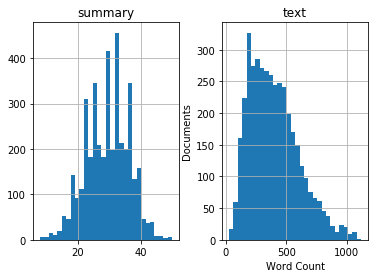

In [9]:
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in df['text']:
      text_word_count.append(len(i.split(' ')))

for i in df['summary']:
      summary_word_count.append(len(i.split(' ')))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.ylabel('Documents')
plt.xlabel('Word Count')
plt.savefig('word_count_distro' + str(build_number) + '.png')
plt.show()

Max Text Lengths

In [10]:
max_text_len = max([len(txt) for txt in df['text']])
max_summary_len = max([len(txt) for txt in df['summary']])
print(max_text_len)
print(max_summary_len)

7823
333


### Training-Validation Split

X - Articles text </br>
Y - Summaries

In [11]:
# convert to numpy array
X = np.array(df['text'])
Y = np.array(df['summary'])

In [12]:
x_tr,x_val,y_tr,y_val=train_test_split(X,Y,test_size=test_train_split,random_state=0,shuffle=True)
print(x_tr.shape)
print(x_val.shape)
print(y_tr.shape)
print(y_val.shape)

(3397,)
(600,)
(3397,)
(600,)


### Word Embeddings - Tokenization

X Tokenizer

In [13]:
word_dict = {}
text = df['text']

for row in text: 
  for word in row.split(" "):
    if word not in word_dict:
      word_dict[word] = 1
    else:
      word_dict[word] += 1

In [14]:
# #prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=len(word_dict)) 
x_tokenizer.fit_on_texts(list(X))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1
print(x_voc)

72199


In [15]:
with open('xtokenizer.pickle', 'wb') as handle:
  pickle.dump(x_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

Y Tokenizer

In [16]:
word_dict = {}
text = df['summary']

for row in text: 
  for word in row.split(" "):
    if word not in word_dict:
      word_dict[word] = 1
    else:
      word_dict[word] += 1

In [17]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=len(word_dict)) 
y_tokenizer.fit_on_texts(list(Y))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1
print(y_voc)

23202


In [18]:
with open('ytokenizer.pickle', 'wb') as handle:
  pickle.dump(y_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Learning Model

#### Encoder Model

In [19]:
encoder_inputs = Input(shape=(max_text_len,))
#embedding layer
enc_emb =  Embedding(x_voc,embedding_dim,trainable=True)(encoder_inputs)
#encoder lstm 
encoder_lstm = LSTM(latent_dim,return_sequences=True,return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)

#### Decoder Model

In [20]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])
                                                          
#dense layer
decoder_dense = Dense(y_voc, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

#### Combined LSTM Model

In [21]:
# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 7823)         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 7823, 128)    9241472     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 128)    2969856     input_2[0][0]                    
____________________________________________________________________________________________

In [22]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

Early Stopping Callback to ensure we stop when Validation Loss is lowest - minimises risk of overfitting

In [23]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2, restore_best_weights=False)

In [ ]:
history = model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:], batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=[es], validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 3397 samples, validate on 600 samples
Epoch 1/2
3397/3397 [==============================] - 831s 245ms/step - loss: 2.1687 - val_loss: 0.7860
Epoch 2/2
1680/3397 [=============>................] - ETA: 6:40 - loss: 0.7761

In [0]:
model.save('model' + str(build_number) + '.h5')

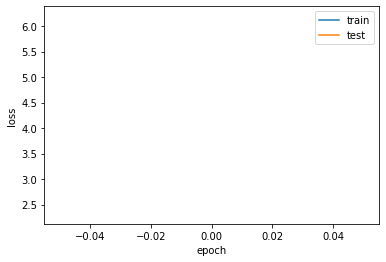

In [0]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.savefig('loss' + str(build_number) + '.png')
plt.show()

## Inference Model

In [0]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word

In [0]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))
decoder_state_inputs = [decoder_state_input_h, decoder_state_input_c]

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_state_inputs)

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2) 

# Final decoder model
decoder_model = Model([decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c], [decoder_outputs2] + [state_h2, state_c2])

In [0]:
encoder_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 7301)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 7301, 128)         3803136   
_________________________________________________________________
lstm_1 (LSTM)                [(None, 7301, 128), (None 131584    
Total params: 3,934,720
Trainable params: 3,934,720
Non-trainable params: 0
_________________________________________________________________


In [0]:
decoder_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 128)    489728      input_2[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 128)          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 128)          0                                            
____________________________________________________________________________________________

### Methhods for Reversing Word Embeddings

In [0]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

### Summarisation Method 

In [0]:
def decode_sequence(input_seq): 
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    target_seq = np.zeros((1, max_summary_len))
    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
      output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c]) 
      # print(output_tokens[0, -1, :][1:])
      sampled_token_index = np.argmax(output_tokens[0, -1, :])
      # print(sampled_token_index)
      # print(sampled_token_index)
      if (sampled_token_index != 0 ):
        sampled_token = reverse_target_word_index[sampled_token_index]
        decoded_sentence += ' '+sampled_token
      else :
        stop_condition = True
      if (len(decoded_sentence.split()) >= (max_summary_len-1)):
              stop_condition = True
       # Update the target sequence (of length 1).
      # target_seq = np.zeros((1,1))
      target_seq = np.zeros((1, max_summary_len))
      target_seq[0, sampled_token_index] = 1

      # Update internal states
      e_h, e_c = h, c
      
    return decoded_sentence

## Test Model Output

Note: *I think there isn't enough data being passed in and so the argmax value always is 0 - it can't learn what should be next*

In [0]:
for i in range(0,1):
    print("Article:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    x_i = x_tr[i].reshape(1,max_text_len)
    print("Generated summary:",decode_sequence(x_i))
    print("\n")

Article: a prosecute attorney greet jury george zimmerman trial monday quote full expletive adversary decide appropriate tell juror knockknock joke and begin opening statement zimmermans longanticipated murder trial in case ignite national debate gun law race relation zimmerman neighborhood watch captain accuse seconddegree murder fatal shoot 17yearold trayvon martin february 2012 sanford florida prosecutor john guys first word sixwoman jury may raise eyebrow good morning fg punk get away guy quote zimmerman these word grown man mouth follow boy didnt know those word mine zimmerman guy say get car pistol two flashlight follow trayvon benjamin martin walk home 7eleven arm fruit drink bag candy eventually two become entangle ground fight a witness say martin top zimmerman guy say the defendant claim trayvon martin top say go die tonight say guy nobody heard guy told juror witness saw happen night shoot begin end witnesses saw slice happen say we confident end trial know head heart stomac

## Evaluation

Using ROUGE (Recall-Orientated Understanding Gisting Evaluation) to evaluate the generated summaries

In [0]:
def get_overlapping_words(x, y):
  num=0
  x = nltk.word_tokenize(x)
  y = nltk.word_tokenize(y)
  for word in y:
    if word in x:
      num = num+1
      x.remove(word)
    else:
      return num

def precision(target, generated):
  length = len(target)
  for i in range (0, length):
    num_overlapping_words = get_overlapping_words(target[i], generated[i])
    generated_summary_len = len(generated[i])
    if generated_summary_len == 0 :
        return 0.0
    else : 
      return num_overlapping_words / generated_summary_len

### For Training Data

In [0]:
print(len(x_tr))

610


In [0]:
val_target_summary = []
val_generated_summary = []
# x_val_len = len(x_val)
x_val_len = 1
for i in range(0,x_val_len):
  print(i)
  val_target_summary.append((y_val[i]))
  x_i = x_val[i].reshape(1,max_text_len)
  val_generated_summary.append(decode_sequence(x_i))

0
1
2
3
4
5
6
7
8
9


In [0]:
print("precision : " + str(precision(tr_target_summary, tr_generated_summary)))

precision : 0.0


### For Validation Data

In [0]:
val_target_summary = []
val_generated_summary = []
# x_val_len = len(x_val)
x_val_len = 1
for i in range(0,x_val_len):
  print(i)
  val_target_summary.append((y_val[i]))
  x_i = x_val[i].reshape(1,max_text_len)
  val_generated_summary.append(decode_sequence(x_i))

0


In [0]:
# pre = precision(val_target_summary, val_generated_summary)
# print(pre)
# print("precision : " + str(pre))

TypeError: ignored

# Inputting New Data

In [0]:
def getpos(word):
  pos = nltk.pos_tag([word])[0][1][0]
  wordnet_conv = {"J": wn.ADJ, "N": wn.NOUN, "V": wn.VERB, "R": wn.ADV}
  if pos in wordnet_conv.keys():
    return wordnet_conv.get(pos)
  return ""

In [0]:
def lemmatization(text):
  lemmatizer = WordNetLemmatizer()
  text_tokenized = inp_df['text'].apply(lambda x: nltk.word_tokenize(x))
  print("lemmatize with pos")
  for i in range(0,len(text_tokenized)):
    text_lemmatized = []
    for word in text_tokenized[i]:
      pos = getpos(word)
      if pos != "":
        lemma = lemmatizer.lemmatize(word, pos)
        text_lemmatized.append(lemma)
      else :
        text_lemmatized.append(word)
    text_lemmatized = ' '.join(map(str, text_lemmatized))
    inp_df['text'][i] = text_lemmatized


In [0]:
input1 = "(CNN) — Earlier this year, Delta Air Lines announced a rethink on reclining seats. In an effort to disrupt fewer passengers' travel experiences, Delta said it'd begin revamping some of its jets to reduce the recline of coach seats from four inches to two inches and the recline of first class seats from 5.5 inches to 3.5 inches. For those who abhor the recline option, it's a small step. And for those who value it, well, it's a compromise. This seemingly innocuous topic is one where there are very much two minds on what's acceptable and what's not. Two CNN Travel staffers engage in a friendly debate about seat recline. Your seat. Your decision. Stacey Lastoe, senior editor at CNN Travel, is of above-average height and makes no apology about reclining; it's her right as a plane, train and bus passenger. She encourages the person sitting in front of her to recline as well. On the first leg of my flight to Japan for my honeymoon, my husband and I got upgraded to first class. Although it would just be a few hours in the sky en route to Dallas, I was excited about sipping Champagne, sitting back and relaxing. Flute in hand, I pushed back to recline my seat for maximum relaxation. But it would not budge; I appeared to be stuck in a dysfunctional seat. Or was I? Turns out the gentleman behind me had a dog in a crate down between his legs, positioned so the seat in front of his -- my seat -- had nowhere to go. Because we were newlyweds and loving every moment of it, I did not mind when my husband turned to the man and told him his wife wanted to recline her seat and asked if he could please rearrange his dog crate to allow for everyones comfort."
inp_df = pd.DataFrame(columns=['text', 'summary'])
inp_df = inp_df.append({'text': str(input1), 'summary': ""}, ignore_index=True)
inp_df.head()

,text,summary
0,"(CNN) — Earlier this year, Delta Air Lines ann...",


In [0]:
inp_df['text'] = inp_df['text'].apply(lambda x: re.sub(r'\(CNN\)|--|[^\w\s\.]','',x)).apply(lambda x: re.sub(r'(\.(?=[\s\r\n]|$))','',x)).apply(lambda x: re.sub(r'\n',' ',x)).apply(lambda x: re.sub(r'\.','',x))

In [0]:
# remove stop words
stop_words = set(stopwords.words('english'))
inp_df['text'] = inp_df['text'].apply(lambda x: nltk.word_tokenize(x)).apply(lambda x: " ".join([word for word in x if not word in stop_words]))

In [0]:
#lemmatize
lemmatization(inp_df['text'])
print(inp_df['text'])

lemmatize with pos
0    Earlier year Delta Air Lines announce rethink ...
Name: text, dtype: object


In [0]:
seq = np.array(inp_df['text'])
print(seq)

['Earlier year Delta Air Lines announce rethink recline seat In effort disrupt few passenger travel experience Delta say itd begin revamp jet reduce recline coach seat four inch two inch recline first class seat 55 inch 35 inch For abhor recline option small step And value well compromise This seemingly innocuous topic one much two mind whats acceptable whats Two CNN Travel staffer engage friendly debate seat recline Your seat Your decision Stacey Lastoe senior editor CNN Travel aboveaverage height make apology recline right plane train bus passenger She encourages person sit front recline well On first leg flight Japan honeymoon husband I get upgraded first class Although would hour sky en route Dallas I excite sip Champagne sit back relax Flute hand I push back recline seat maximum relaxation But would budge I appear stuck dysfunctional seat Or I Turns gentleman behind dog crate leg position seat front seat nowhere go Because newlywed love every moment I mind husband turn man told wi

In [0]:
seq_tokenizer = x_tokenizer.texts_to_sequences(seq)
#padding zero upto maximum length
seq_tokenizer_padded = pad_sequences(seq_tokenizer,  maxlen=max_text_len, padding='post')

summary = decode_sequence(seq_tokenizer_padded)

# print(seq2text(seq))
print("---")
print("Summary: " + summary)

---
Summary: 
